## 4- Daily Summary Table

How to import the daily summary table & demonstrations of what information it has.

Written by Jess Breda May 2023

### 1.1 Libraries

In [293]:
from create_summary_table import fetch_daily_summary_info
from plot_summary_table import *

import seaborn as sns
import matplotlib.pyplot as plt

# settings
%load_ext autoreload
%autoreload 2

sns.set_context("talk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.2 Assumptions

1. This code will grab info for any date when the animal had an entry in the `Sessions` table or the `Mass` table.

2. It is pulling the restriction volume from the `Water` table. This volume only gets entered if pub is run that day. If there is no entry, it defaults to 4% for mice and 3% for rats. 

### 2. Fetch for a single animal

Create the daily summary dataframe using the `fetch_daily_summary_info` function. If you have the datajoint environment set up (see README), this should run for any animal(s). 

In [342]:
ANIMAL_ID = ["A325"]

animal_df = fetch_daily_summary_info(animal_ids=ANIMAL_ID, date_min="2023-05-01")

rig volume was empty on 2023-05-09, defaulting to 0 mL
mass data not found for A325 on 2023-05-10, but animal trained using previous days mass
rig volume was empty on 2023-05-12, defaulting to 0 mL
rig volume was empty on 2023-05-13, defaulting to 0 mL
rig volume was empty on 2023-05-14, defaulting to 0 mL
rig volume was empty on 2023-05-15, defaulting to 0 mL
rig volume was empty on 2023-05-16, defaulting to 0 mL
rig volume was empty on 2023-05-17, defaulting to 0 mL
rig volume was empty on 2023-05-18, defaulting to 0 mL
rig volume was empty on 2023-05-21, defaulting to 0 mL
rig volume was empty on 2023-05-25, defaulting to 0 mL
rig volume was empty on 2023-05-26, defaulting to 0 mL
rig volume was empty on 2023-05-27, defaulting to 0 mL
fetched 25 daily summaries for A325 between 2023-05-01 and 2023-05-27


In [343]:
animal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   animal_id       25 non-null     object 
 1   date            25 non-null     object 
 2   rigid           14 non-null     object 
 3   n_done_trials   14 non-null     float64
 4   n_sessions      25 non-null     int64  
 5   start_time      14 non-null     object 
 6   train_dur_hrs   25 non-null     float64
 7   trial_rate      14 non-null     float64
 8   hit_rate        14 non-null     float64
 9   viol_rate       14 non-null     float64
 10  side_bias       14 non-null     float64
 11  mass            25 non-null     float64
 12  tech            24 non-null     object 
 13  percent_target  25 non-null     float64
 14  pub_volume      25 non-null     float64
 15  rig_volume      25 non-null     float64
 16  volume_target   25 non-null     float64
 17  water_diff      25 non-null     float

In [344]:
animal_df.head()

,animal_id,date,rigid,n_done_trials,n_sessions,start_time,train_dur_hrs,trial_rate,hit_rate,viol_rate,side_bias,mass,tech,percent_target,pub_volume,rig_volume,volume_target,water_diff
0,A325,2023-05-01,Rig205,604.0,1,11:11:00,2.29,263.76,0.75,0.04,0.00,478.0,JL,3.0,0.000,16.956,14.34,2.616
1,A325,2023-05-02,Rig205,613.0,1,10:52:57,2.46,249.19,0.74,0.07,0.02,475.0,JL,3.0,0.000,16.404,14.25,2.154
2,A325,2023-05-03,Rig205,507.0,1,11:34:41,1.97,257.36,0.72,0.05,0.00,477.0,KO,3.0,1.116,13.270,14.31,0.076
3,A325,2023-05-04,Rig205,523.0,1,11:12:52,2.25,232.44,0.71,0.07,0.06,487.0,JL,3.0,2.016,12.745,14.61,0.151
4,A325,2023-05-05,Rig205,591.0,1,11:00:05,2.38,248.32,0.72,0.07,0.04,480.0,JL,3.0,0.000,14.995,14.40,0.595


### 3. Visualize

Examples of how to use plotting functions with the daily summary dataframe of a single animal

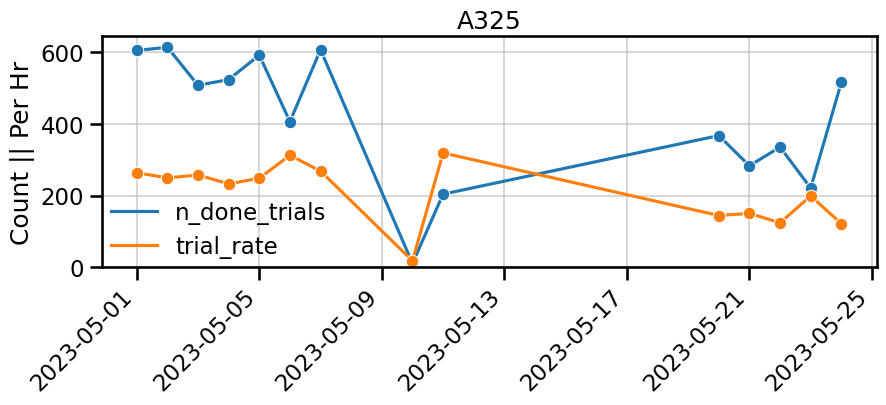

In [345]:
# Plot number of done trials and rate of trials/hr over dates

fig,ax = make_fig() # helper function
plot_trials(animal_df, ax, title= ANIMAL_ID[0], legend=True)


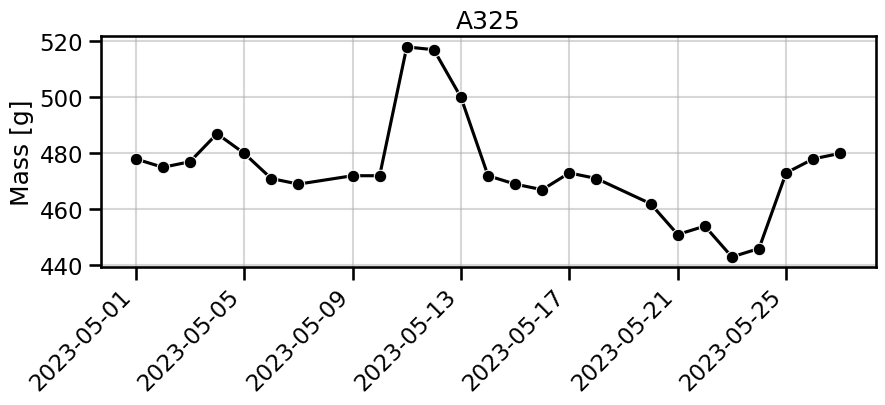

In [346]:
# Plot mass over dates

fig,ax = make_fig()
plot_mass(animal_df, ax, title=ANIMAL_ID[0])


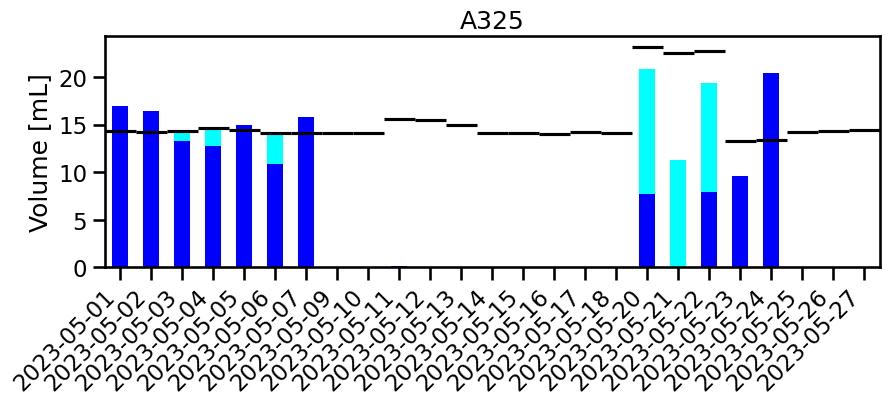

In [347]:
# Plot water restriction over dates

fig,ax = make_fig()
plot_water_restriction(animal_df, ax, title=ANIMAL_ID[0], legend=False)

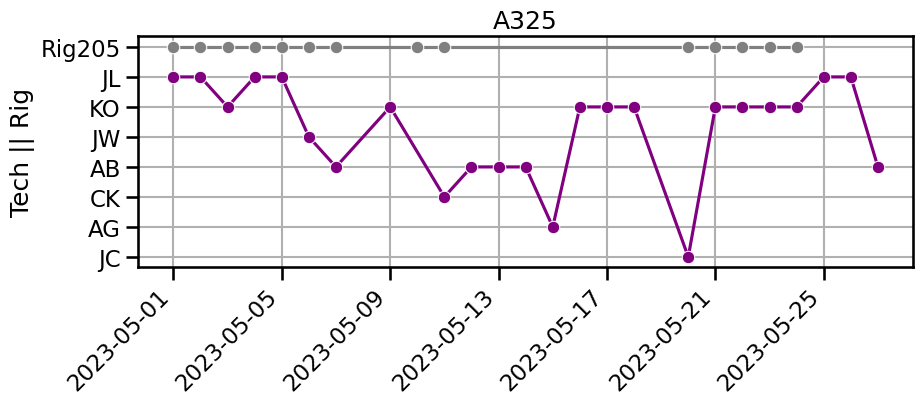

In [348]:
# Plot rig / tech over dates

fig,ax = make_fig()
plot_rig_tech(animal_df, ax, title=ANIMAL_ID[0])


### 4. Extensions

#### 4.1 Multi-plot summary

Here's an example of how to easily make a subplot for an animal using `subplot_mosiac`

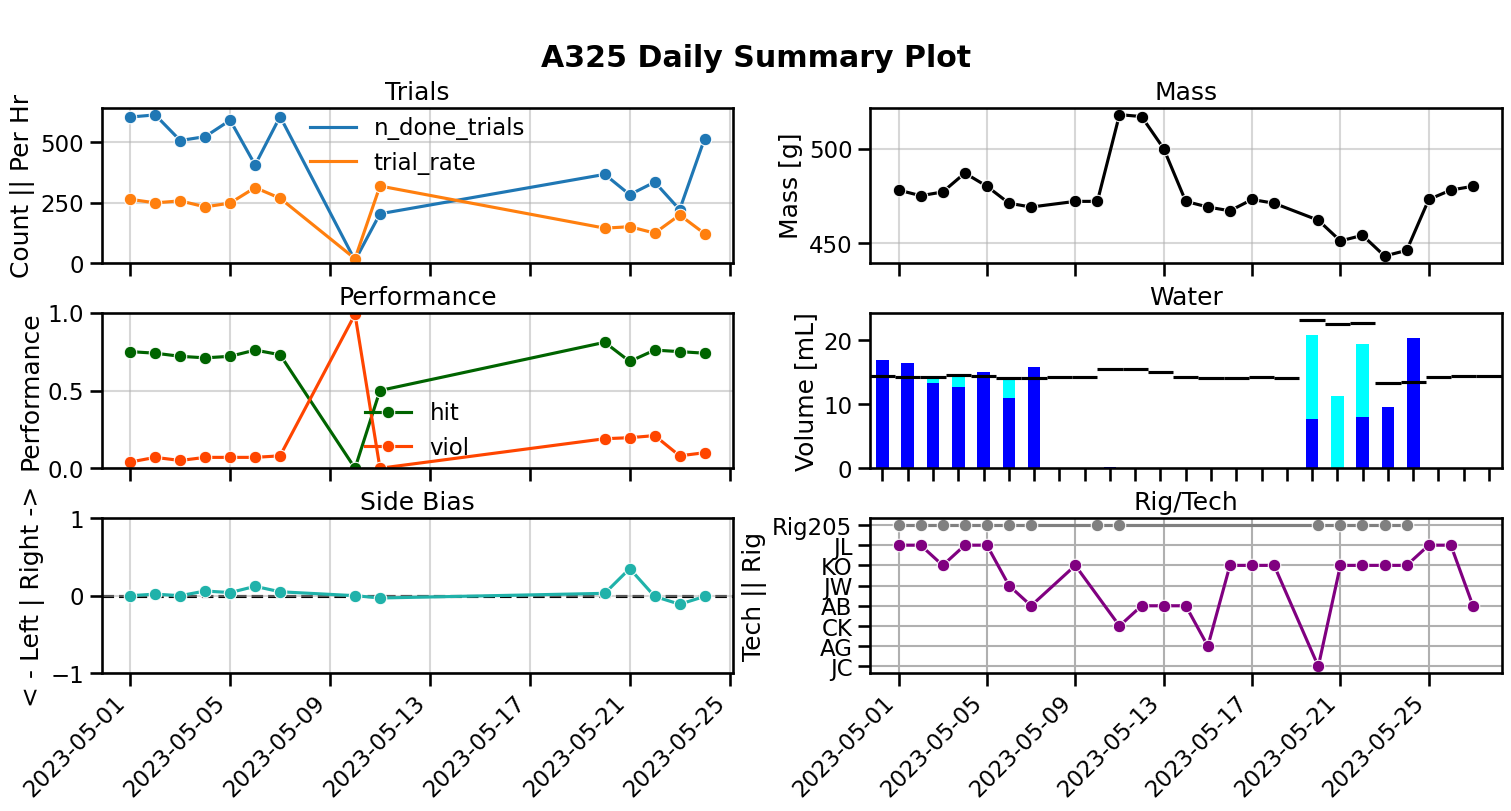

In [349]:

## Initialize mutli-axis figure
layout = """
    AAABBB
    CCCDDD
    EEEFFF
"""
fig = plt.figure(constrained_layout=True, figsize=(15,8))
ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
plt.suptitle(f"\n{ANIMAL_ID[0]} Daily Summary Plot", fontweight="semibold")


## Plot
# left column
plot_trials(animal_df, ax_dict["A"], title="Trials", legend=True, xaxis_label=False)
plot_performance(animal_df, ax_dict["C"], title="Performance", xaxis_label=False)
plot_side_bias(animal_df, ax_dict["E"], title="Side Bias", xaxis_label=True)

# right column
plot_mass(animal_df, ax_dict["B"], title="Mass", xaxis_label=False)
plot_water_restriction(animal_df, ax_dict["D"], title="Water", legend=False, xaxis_label=False)
plot_rig_tech(animal_df, ax_dict["F"], title="Rig/Tech", xaxis_label=True)


#### 4.2 Date window generator

This is handy helper function for generating date windows. For example, I commonly search for 7 days back from the current date. Then, you can only query this date range in datajoint.

In [350]:
date_min, date_max = return_date_window(latest_date=None, n_days_back=7)
print(f"date min = {date_min}, date max = {date_max}")

date min = 2023-05-20, date max = 2023-05-27


In [351]:
dw_df = fetch_daily_summary_info(animal_ids=ANIMAL_ID, date_min=date_min, date_max=date_max)
dw_df

rig volume was empty on 2023-05-21, defaulting to 0 mL
rig volume was empty on 2023-05-25, defaulting to 0 mL
rig volume was empty on 2023-05-26, defaulting to 0 mL
rig volume was empty on 2023-05-27, defaulting to 0 mL
fetched 8 daily summaries for A325 between 2023-05-20 and 2023-05-27


,animal_id,date,rigid,n_done_trials,n_sessions,start_time,train_dur_hrs,trial_rate,hit_rate,viol_rate,side_bias,mass,tech,percent_target,pub_volume,rig_volume,volume_target,water_diff
0,A325,2023-05-20,Rig205,367.0,1,12:15:53,2.54,144.49,0.81000,0.190000,0.030000,462.0,JC,5.0,13.104,7.6957,23.10,-2.3003
1,A325,2023-05-21,Rig205,283.0,2,11:21:26,1.88,150.53,0.68689,0.196537,0.348622,451.0,KO,5.0,11.304,0.0000,22.55,-11.2460
2,A325,2023-05-22,Rig205,335.0,1,15:26:27,2.70,124.07,0.76000,0.210000,-0.010000,454.0,KO,5.0,11.412,7.9188,22.70,-3.3692
3,A325,2023-05-23,Rig205,221.0,1,14:03:06,1.11,199.10,0.75000,0.080000,-0.110000,443.0,KO,0.0,0.000,9.5638,13.29,-3.7262
4,A325,2023-05-24,Rig205,515.0,1,15:01:56,4.23,121.75,0.74000,0.100000,-0.010000,446.0,KO,0.0,0.000,20.3700,13.38,6.9900
5,A325,2023-05-25,NaN,NaN,0,NaN,0.00,NaN,NaN,NaN,NaN,473.0,JL,0.0,0.000,0.0000,14.19,-14.1900
6,A325,2023-05-26,NaN,NaN,0,NaN,0.00,NaN,NaN,NaN,NaN,478.0,JL,0.0,0.000,0.0000,14.34,-14.3400
7,A325,2023-05-27,NaN,NaN,0,NaN,0.00,NaN,NaN,NaN,NaN,480.0,AB,0.0,0.000,0.0000,14.40,-14.4000


#### 4.3 Multiple animals

The code allows you to fetch multiple animals at a time by passing in a list. You can then use `groupby` functions for plotting

In [352]:
# Load in 

MULTIANIMAL_IDS = ["R610", "W600"]
mutlianimal_df = fetch_daily_summary_info(animal_ids=MULTIANIMAL_IDS, date_min="2023-05-15")

fetched 13 daily summaries for R610 between 2023-05-15 and 2023-05-27
rig volume was empty on 2023-05-19, defaulting to 0 mL
fetched 13 daily summaries for W600 between 2023-05-15 and 2023-05-27


In [353]:
# Check that mutlianimal load in worked
mutlianimal_df.animal_id.unique()

array(['R610', 'W600'], dtype=object)

<Axes: title={'center': 'Mean trial rate'}, xlabel='animal_id'>

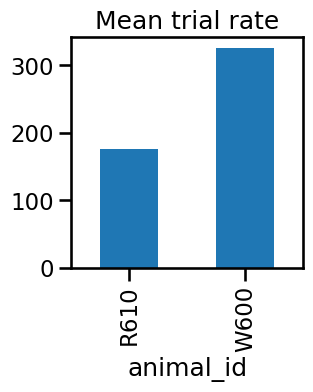

In [354]:
# Plot average trial rate per animal

fig,ax=make_fig((3,3))
mutlianimal_df.groupby(
    ["animal_id"]
    ).trial_rate.mean().plot(
    kind="bar", title="Mean trial rate"
    )

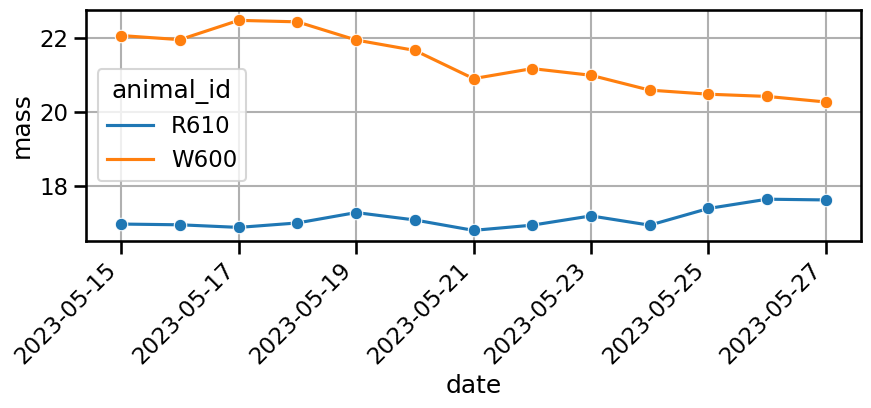

In [355]:
## Plot mass over time conditioned on animal id

fig,ax = plt.subplots(1,1, figsize=(10,3))

sns.lineplot(data=mutlianimal_df, x="date", y="mass", hue="animal_id", marker="o", ax=ax)

set_date_x_ticks(ax,xaxis_label=True)
ax.grid()

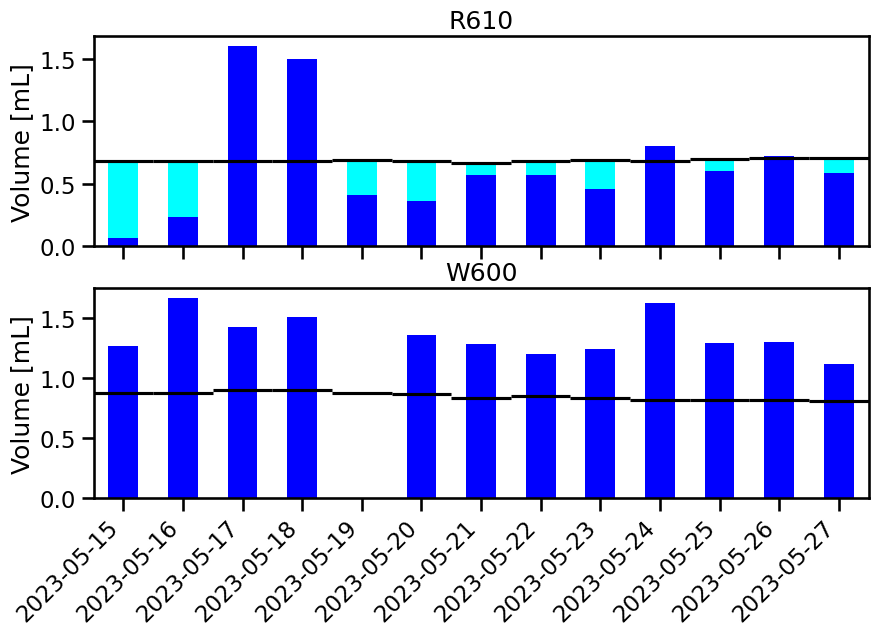

In [356]:
# Plot water restriction over time conditioned on animal id

fig,ax = plt.subplots(2,1, figsize=(10,6), sharex=True)

for ii, (animal_id, sub_df) in enumerate(mutlianimal_df.groupby("animal_id")):
    plot_water_restriction(sub_df, ax[ii], title=animal_id, legend=False, xaxis_label=True)


#### 4.4 Overwrite checks

Making the summary data frame is time consuming. To avoid this you can do a "lazy load" and only read in the new dates from bdata and merge this with a dataframe containing the previous dates.

This functionality is implemented with the `overwrite`, `save_out` and `save_path` variables.